## Macromolecular model

This case study follows from the model presented in:

*Omta et al. 2017. Extracting physiological traits from batch and chemostate culture data. L&O*

The equations are below.

\begin{equation} \frac{dC}{dt} = (C_{syn} - E)P \end{equation}
\begin{equation} \frac{dP}{dt} = P_{syn}P \end{equation}
\begin{equation} \frac{dr}{dt} = \frac{1}{\tau}(r_0 - r) \end{equation}
\begin{equation} \frac{dN}{dt} = -\frac{dP}{dt} \end{equation}

\begin{equation} P_{syn} = \mu\left(\frac{N}{N+K}\right) \end{equation}
\begin{equation} r_0 = b\frac{P}{C} \end{equation}
\begin{equation} r_{cell} = \frac{C}{P} \end{equation}
\begin{equation} E = \frac{1}{2}m_{ex}\left(1+\tanh\left(r_{cell} - r_{ex}\right)\right) \end{equation}

In [1]:
using StanSample, CSV, DataFrames, PyPlot, Statistics

ArgumentError: ArgumentError: Package CSV not found in current path:
- Run `import Pkg; Pkg.add("CSV")` to install the CSV package.


In [2]:
versioninfo()

Julia Version 1.3.0
Commit 46ce4d7933 (2019-11-26 06:09 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin19.0.0)
  CPU: Intel(R) Core(TM) i9-8950HK CPU @ 2.90GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, skylake)
Environment:
  JULIA_CMDSTAN_HOME = /Users/zhenwu/Zhen_WU/cmdstan


In [3]:
data = CSV.read("data/macromolecules.csv");
NH4 = CSV.read("data/flynn_macromolecules.csv");

In [4]:
dat = join(data,NH4,on=:t);
dat = hcat(dat[:,1:4],dat[:,7]);
rename!(dat,Dict(:x1 => "NH4"));
y_data = zeros(size(dat,1),4)
y_data[:,1] = dat[:,4] .* 0.001;
y_data[:,2] = dat[:,2] .* 0.001;
y_data[:,3] = dat[:,3] .* 1000;
y_data[:,4] = dat[:,5] .* 0.08325909;

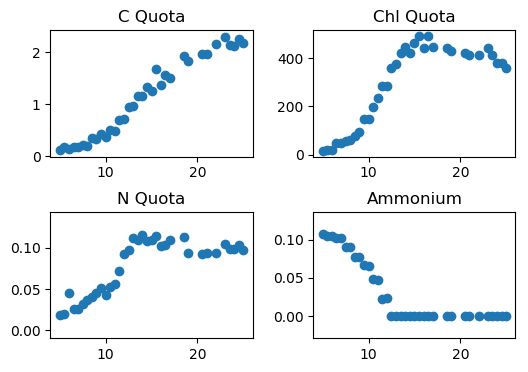

In [5]:
fig, axs = PyPlot.subplots(2, 2, figsize = (6,4))
axs[1].scatter(dat[:,1], y_data[:,1])
axs[2].scatter(dat[:,1], y_data[:,2])
axs[3].scatter(dat[:,1], y_data[:,3])
axs[4].scatter(dat[:,1], y_data[:,4])
axs[1].set_title("C Quota")
axs[2].set_title("N Quota")
axs[3].set_title("Chl Quota")
axs[4].set_title("Ammonium")
fig.subplots_adjust(wspace=0.3, hspace=0.44)

In [6]:
###### macromolecular model stan code
const macromolecularmodel = "functions {
  real[] macro(real   t,           // time
               real[] x,           // state x[1]:CH  x[2]:PR, x[3]:Chl , x[4]:N
               real[] theta,
               real[] x_r,
               int[]  x_i) {       // parameters

    real CNpro = theta[1]; 
    real KN    = theta[2];    
    real mu    = theta[3]; 
    real CHsyn = theta[4]; 
    real m_ex  = theta[5];  
    real R_ex  = theta[6];  
    real tau   = theta[7];
    real b     = theta[8];

    real PRsynth = theta[3]*x[4]/(theta[2]+x[4]);
    real r0      = theta[8]*(x[2]/x[1]);
    real Chl     = x[3]*x[2];
    real Rcell   = x[1]/x[2];
    real excr    = 0.5*theta[5]*(1+tanh(Rcell - theta[6]));
    
    real dCH    = x[2]*(theta[4] - excr);
    real dr     = (1/theta[7])*(r0-x[3]);
    real dPR    = x[2]*PRsynth;
    real dN     = -dPR/(1+exp(-10000*x[4])); 

    return {dCH,dPR,dr,dN};
  }
}
data {
  int<lower = 0> n;           // num obs
  real t_obs[n];              // obs times
  real<lower = 0> y[n,4];     // observed variable at measurement times
}
parameters {
  real<lower = 0> theta[8];   // parameters
  real<lower = 0> x0[4];      // initial population
  real<lower = 1E-15> sigma[4]; // obs error
}
transformed parameters {
  real x[n,4] = integrate_ode_rk45(macro, x0, -1, t_obs, theta, rep_array(0.0,0), rep_array(0,0), 1e-6, 1e-5, 1e3) ;
  for(i in 1:n){
    x[i,3] = x[i,3]*x[i,2]*1E6;
  }
}
model {
  x0[1]    ~ normal(0.1,1);
  x0[2]    ~ normal(0.1,1);
  x0[3]    ~ normal(10,10);
  x0[4]    ~ normal(0.1,1);  
  theta[1] ~ normal(6.6,10); //prior on CHpro
  theta[2] ~ normal(0.002,3); //prior on KN
  theta[3] ~ normal(0.3,1);
  theta[4] ~ normal(5,10);
  theta[5] ~ normal(10,10);
  theta[6] ~ normal(13,10);
  theta[7] ~ normal(10,10); 
  theta[8] ~ normal(0.05,5); 
  
  for(i in 1:4){
    y[1:n,i] ~ normal(x[1:n,i], sigma[i]);
  }
}";

In [7]:
macromoleculardata = Dict("n" => size(dat,1), "t_obs" => dat[:,1], "y" => y_data);

In [19]:
sm = SampleModel("MacroMolecularModel", macromolecularmodel)


/Users/zhenwu/Zhen_WU/Stan_julia/macromolecular/tmp/MacroMolecularModel.stan updated.


In [20]:
(sample_file, log_file) = stan_sample(sm, data=macromoleculardata, n_chains = 4);

In [29]:
chns = read_samples(sm)

Object of type Chains, with data of type 1000×163×4 Array{Float64,3}

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
internals         = accept_stat__, divergent__, energy__, lp__, n_leapfrog__, stepsize__, treedepth__
parameters        = sigma.1, sigma.2, sigma.3, sigma.4, theta.1, theta.2, theta.3, theta.4, theta.5, theta.6, theta.7, theta.8, x0.1, x0.2, x0.3, x0.4, x.1.1, x.1.2, x.1.3, x.1.4, x.2.1, x.2.2, x.2.3, x.2.4, x.3.1, x.3.2, x.3.3, x.3.4, x.4.1, x.4.2, x.4.3, x.4.4, x.5.1, x.5.2, x.5.3, x.5.4, x.6.1, x.6.2, x.6.3, x.6.4, x.7.1, x.7.2, x.7.3, x.7.4, x.8.1, x.8.2, x.8.3, x.8.4, x.9.1, x.9.2, x.9.3, x.9.4, x.10.1, x.10.2, x.10.3, x.10.4, x.11.1, x.11.2, x.11.3, x.11.4, x.12.1, x.12.2, x.12.3, x.12.4, x.13.1, x.13.2, x.13.3, x.13.4, x.14.1, x.14.2, x.14.3, x.14.4, x.15.1, x.15.2, x.15.3, x.15.4, x.16.1, x.16.2, x.16.3, x.16.4, x.17.1, x.17.2, x.17.3, x.17.4, x.18.1, x.18.2, x.18.3, x.18.4, x.19.1, x.19.2, x.19.3, x.19.4,

In [30]:
ESS = ess(chns)

ESS

│ Row │ parameters │ ess     │ r_hat    │
│     │ Symbol     │ Any     │ Any      │
├─────┼────────────┼─────────┼──────────┤
│ 1   │ sigma.1    │ 4062.39 │ 0.999365 │
│ 2   │ sigma.2    │ 2761.85 │ 0.999905 │
│ 3   │ sigma.3    │ 3429.79 │ 1.00002  │
│ 4   │ sigma.4    │ 2994.86 │ 0.999829 │
│ 5   │ theta.1    │ 4037.05 │ 1.00013  │
│ 6   │ theta.2    │ 1280.46 │ 1.00043  │
│ 7   │ theta.3    │ 1105.73 │ 1.00047  │
│ 8   │ theta.4    │ 1974.03 │ 1.00293  │
│ 9   │ theta.5    │ 3353.67 │ 1.00078  │
│ 10  │ theta.6    │ 1811.41 │ 0.999502 │
│ 11  │ theta.7    │ 2856.36 │ 1.00219  │
│ 12  │ theta.8    │ 2076.08 │ 1.00135  │
│ 13  │ x0.1       │ 1537.54 │ 1.00103  │
│ 14  │ x0.2       │ 1033.02 │ 1.00047  │
│ 15  │ x0.3       │ 1315.19 │ 1.00151  │
│ 16  │ x0.4       │ 1559.03 │ 1.00085  │
│ 17  │ x.1.1      │ 1696.72 │ 1.00096  │
│ 18  │ x.1.2      │ 1047.69 │ 1.00017  │
│ 19  │ x.1.3      │ 2181.36 │ 0.999937 │
│ 20  │ x.1.4      │ 3220.55 │ 1.00052  │
│ 21  │ x.2.1      │ 1720.79 

In [22]:
rawdata = DataFrame(chns, showall=true, sorted=true, append_chains=true);

In [23]:
rawdata[:,17:end]
dat_summary = zeros(35,4,4)
for i in 1:35
    for j in 1:4
        dat_summary[i,j,1] = mean(rawdata[:,16+4*(i-1)+j])
        dat_summary[i,j,2] = std(rawdata[:,16+4*(i-1)+j])
        dat_summary[i,j,3] = quantile(rawdata[:,16+4*(i-1)+j],0.025)
        dat_summary[i,j,4] = quantile(rawdata[:,16+4*(i-1)+j],0.975)
    end
end

In [34]:
dat_mean = chns.info[1].x[2][1][17:end,2];
dat_std = chns.info[1].x[2][1][17:end,3];
dat_97 = chns.info[1].x[2][2][17:end,6];
dat_2 = chns.info[1].x[2][2][17:end,2];

In [35]:
data_mean = reverse(rotl90(reshape(dat_mean,4,35)),dims=1)
data_std = reverse(rotl90(reshape(dat_std,4,35)),dims=1)
data_97 = reverse(rotl90(reshape(dat_97,4,35)),dims=1)
data_2 = reverse(rotl90(reshape(dat_2,4,35)),dims=1);

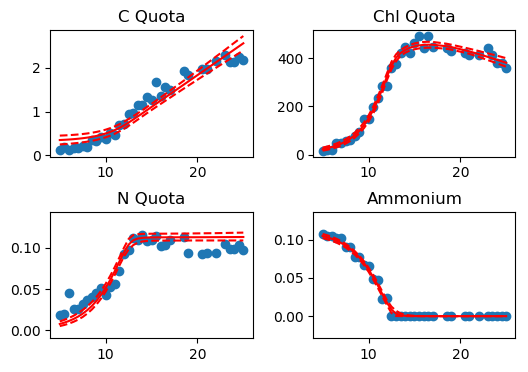

In [36]:
fig, axs = PyPlot.subplots(2, 2, figsize = (6,4))
axs[1].scatter(dat[:,1], y_data[:,1])
axs[1].plot(dat[:,1], data_mean[:,1],"r")
axs[1].plot(dat[:,1], data_2[:,1],"r--")
axs[1].plot(dat[:,1], data_97[:,1],"r--")
axs[2].scatter(dat[:,1], y_data[:,2])
axs[2].plot(dat[:,1], data_mean[:,2],"r")
axs[2].plot(dat[:,1], data_2[:,2],"r--")
axs[2].plot(dat[:,1], data_97[:,2],"r--")
axs[3].scatter(dat[:,1], y_data[:,3])
axs[3].plot(dat[:,1], data_mean[:,3],"r")
axs[3].plot(dat[:,1], data_2[:,3],"r--")
axs[3].plot(dat[:,1], data_97[:,3],"r--")
axs[4].scatter(dat[:,1], y_data[:,4])
axs[4].plot(dat[:,1], data_mean[:,4],"r")
axs[4].plot(dat[:,1], data_2[:,4],"r--")
axs[4].plot(dat[:,1], data_97[:,4],"r--")
axs[1].set_title("C Quota")
axs[2].set_title("N Quota")
axs[3].set_title("Chl Quota")
axs[4].set_title("Ammonium")
fig.subplots_adjust(wspace=0.3, hspace=0.44)

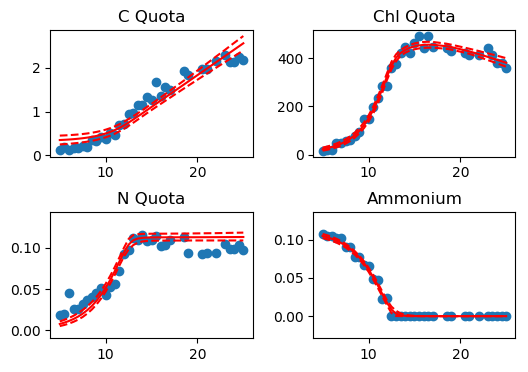

In [37]:
fig, axs = PyPlot.subplots(2, 2, figsize = (6,4))
axs[1].scatter(dat[:,1], y_data[:,1])
axs[1].plot(dat[:,1], dat_summary[:,1,1],"r")
axs[1].plot(dat[:,1], dat_summary[:,1,3],"r--")
axs[1].plot(dat[:,1], dat_summary[:,1,4],"r--")
axs[2].scatter(dat[:,1], y_data[:,2])
axs[2].plot(dat[:,1], dat_summary[:,2,1],"r")
axs[2].plot(dat[:,1], dat_summary[:,2,3],"r--")
axs[2].plot(dat[:,1], dat_summary[:,2,4],"r--")
axs[3].scatter(dat[:,1], y_data[:,3])
axs[3].plot(dat[:,1], dat_summary[:,3,1],"r")
axs[3].plot(dat[:,1], dat_summary[:,3,3],"r--")
axs[3].plot(dat[:,1], dat_summary[:,3,4],"r--")
axs[4].scatter(dat[:,1], y_data[:,4])
axs[4].plot(dat[:,1], dat_summary[:,4,1],"r")
axs[4].plot(dat[:,1], dat_summary[:,4,3],"r--")
axs[4].plot(dat[:,1], dat_summary[:,4,4],"r--")
axs[1].set_title("C Quota")
axs[2].set_title("N Quota")
axs[3].set_title("Chl Quota")
axs[4].set_title("Ammonium")
fig.subplots_adjust(wspace=0.3, hspace=0.44)

In [38]:
cnames=["CNpro","KN","mu","CHsyn","m_ex","R_ex","tau","b"]
fig, axs = PyPlot.subplots(4, 2, figsize = (8,8))
for i in 1:8
    axs[i].scatter(collect(1:1:4000), rawdata[:,4+i],s=1)
    axs[i].plot(collect(1:1:4000),zeros(4000).+chns.info[1].x[2][1][4+i,2],"r")
    axs[i].set_title(cnames[i], ha="center", fontsize=12, color = "k");
end
fig.subplots_adjust(bottom=0.1, top=0.96, left=0.1, right=0.95,
                    wspace=0.2, hspace=0.4)

In [39]:
fig, axs = PyPlot.subplots(4, 2, figsize = (8,8))
for i in 1:8
    axs[i].hist(rawdata[:,4+i],bins=20)
    axs[i].axvline(chns.info[1].x[2][1][4+i,2],color="r")
    axs[i].set_title(cnames[i], ha="center", fontsize=12, color = "k");
end

fig.subplots_adjust(bottom=0.1, top=0.96, left=0.1, right=0.95,
                    wspace=0.2, hspace=0.4)